# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [13]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
날씨 데이터 세트

Max Planck Institute for Biogeochemistry에 의해 기록 된 [날씨 시계열 데이터 세트]를 사용

대기 온도, 대기압 및 습도와 같은 14 가지 특징으로 구성
2009 년과 2016 년 사이에 수집 된 데이터 만 사용

In [14]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

C:\Users\hjsong\.keras\datasets\jena_climate_2009_2016.csv


In [15]:
#pandas dataframe으로 csv파일 read
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [16]:
# 상위 데이터 목록 확인
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


10 분마다 기록된 데이터 (한 시간 동안 6 개의 관측 값), 하루에 144 개 (6x24)의 관측치가 포함
특정 시간이 주어지면 앞으로 6 시간 동안 온도를 예측
이 예측을하기 위해 5 일간의 관찰을 사용하도록 선택
학습을 위해 마지막 720 (5x144) 관측 값이 포함 된 window를 만들어 적용

* univariate_data()  
모델이 학습할 때 사용할 window를 반환  
매개 변수 history_size : 과거 정보 window size, target_size : 예측 레이블.  

In [17]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

데이터의 처음 300,000 개 행은 학습 데이터 세트(2100일 분량)이고 나머지는 유효성 검사 데이터 세트로 구성

In [18]:
TRAIN_SPLIT = 300000

재현성을 보장하기 위해 시드 설정.

In [19]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series

#### 단일 특징 (온도, temperature) 만 사용하여 모델을 학습하고 해당 값을 예측

### (1)데이터 셋에서 온도만 추출

In [20]:
#extract only the temperature from the dataset.
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

### (2)시간에 따른 온도 시각화

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000104DB9E8>],
      dtype=object)

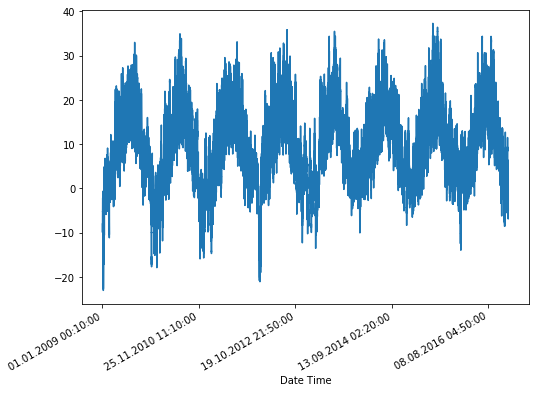

In [21]:
uni_data.plot(subplots=True)

### (3)Standardization  
- 평균, 표준편차를 구하여 스케일링 처리  
- keras.utils.normalize를 이용하여 [0,1] 범위로 재조정 하는 방법을 사용해도됨

In [24]:
#uni_data에서 값만 추출
uni_data = uni_data.values

In [25]:
#평균, 표준편차 구하기
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [26]:
# Standardization (표준화)
uni_data = (uni_data-uni_train_mean)/uni_train_std

### (4) univariate_data 추출
지난 20 개의 온도 관측 기록을 사용하여 데이터 추출

In [28]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

`univariate_data` function 결과 확인

In [29]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.104184859810088


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [30]:
def create_time_steps(length):
  return list(range(-length, 0))

In [55]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

0
1


<module 'matplotlib.pyplot' from 'C:\\Program Files\\Anaconda201812\\lib\\site-packages\\matplotlib\\pyplot.py'>

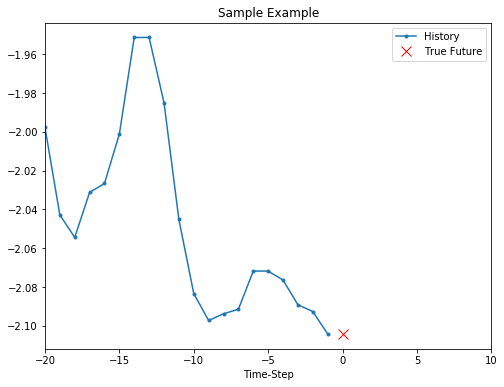

In [41]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### (5) Baseline
모델 학습전에 기준선 결정, 과거 20개 관측값의 평균점을 모델 예측으로 정하여 출력

In [42]:
def baseline(history):
  return np.mean(history)

0
1
2


<module 'matplotlib.pyplot' from 'C:\\Program Files\\Anaconda201812\\lib\\site-packages\\matplotlib\\pyplot.py'>

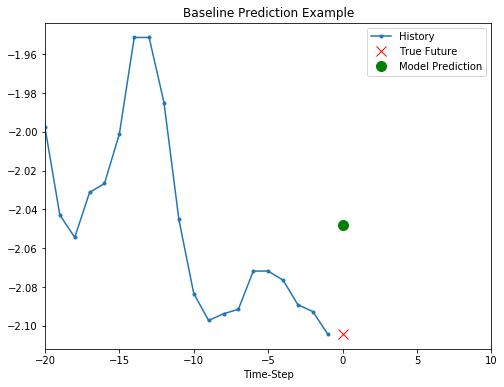

In [43]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

### Recurrent neural network

LSTM 을 사용하여 예측모델 구성

### (6) LSTM 데이터 입력  구조

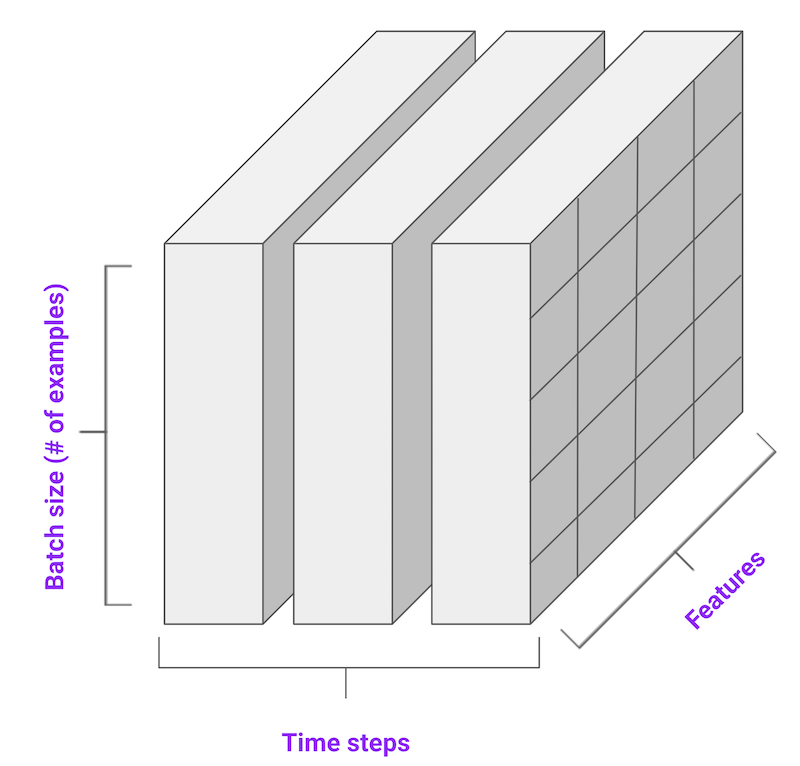

In [45]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### (7) LSTM model 구성

In [47]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),         #output unit size = 8
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')   #regression

### (8) sample prediction

모든 데이터를 예측하여  모델의 출력 결과  확인


In [50]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


### (9)train the model


In [51]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0200 - val_loss: 0.0149
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0194 - val_loss: 0.0146
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0189 - val_loss: 0.0145
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0183 - val_loss: 0.0136
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0155 - val_loss: 0.0134
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0178 - val_loss: 0.0131
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0166 - val_loss: 0.0128
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0166 - val_loss: 0.0126
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0166 - val_loss: 0.0125
Epoch 10/10
200/200 [==============================] - 1s

### Predict using the simple LSTM model
학습된 simple LSTM으로 예측결과 확인

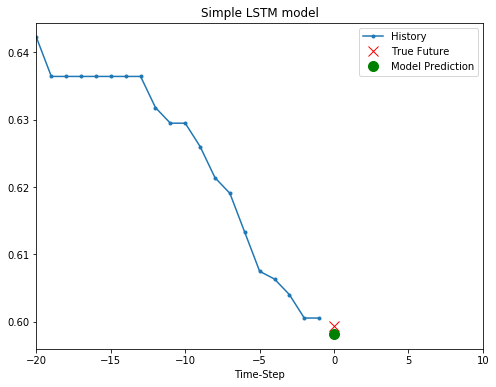

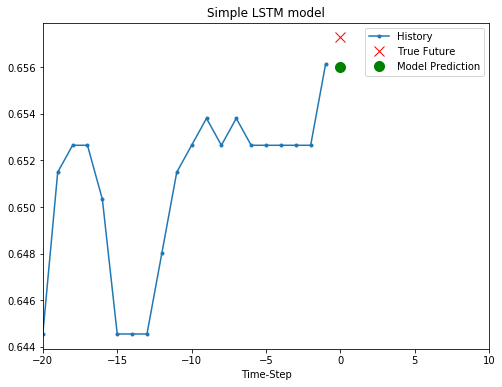

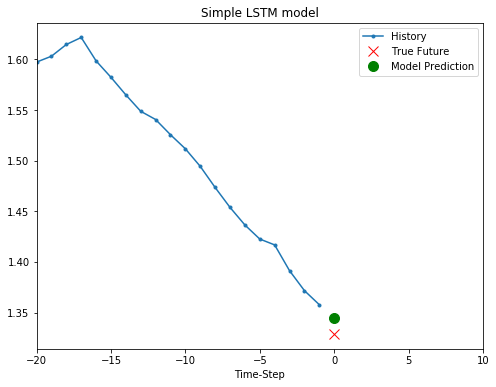

In [56]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()